In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility processing imports
from utilities.processing_utility import get_q_2_cw_data 

# utility plotting imports
from utilities.plotting_utility import plot_daily


In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


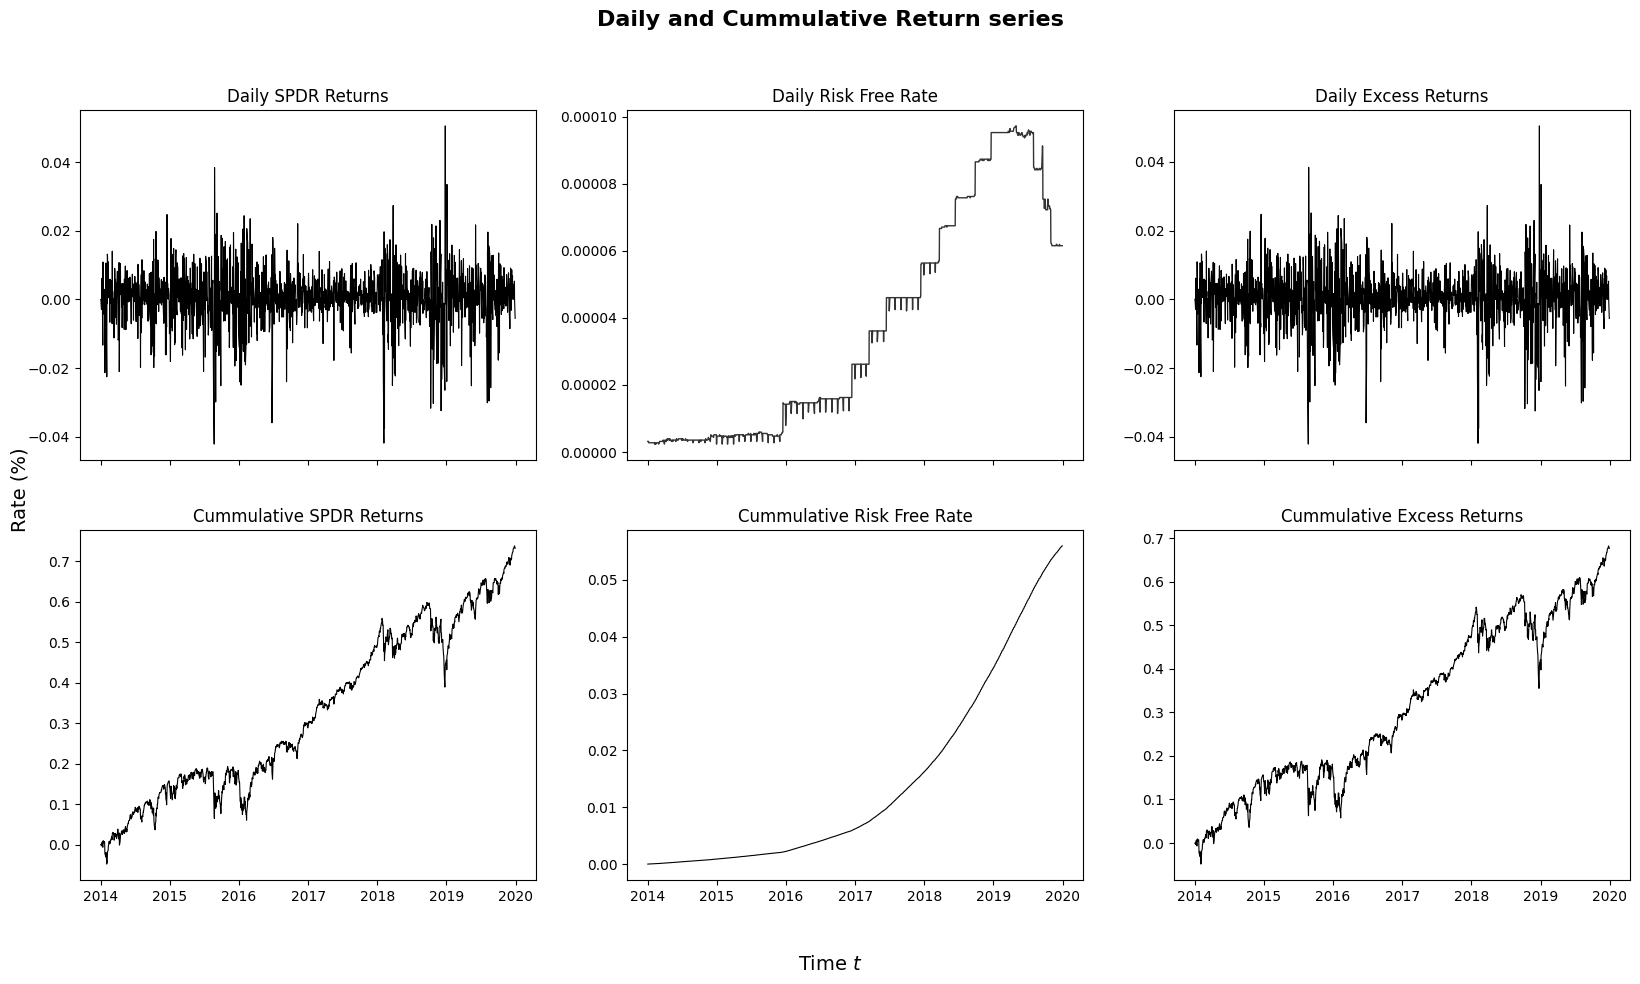

In [3]:
daily_returns_fig = plot_daily(df)

# save figure
daily_returns_fig.savefig('figures/01_daily_returns.png')

Text(0.09, 0.5, 'Rate (%)')

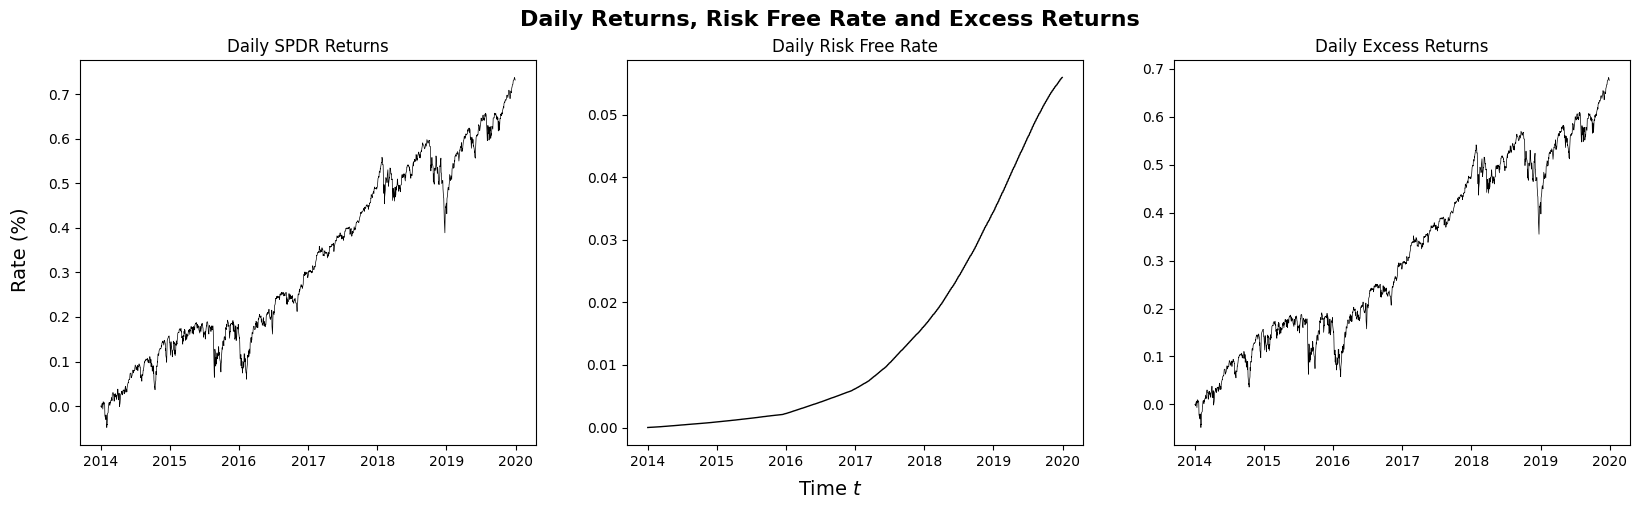